<a href="https://colab.research.google.com/github/hariszaf/metabolic_toy_model/blob/main/Copy_of_DNNGIORtraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Use DNNGIOR On Your Own Training Set**

## Google Collab part

In [ ]:
# @title Install dependencies
!pip install tensorflow==2.15.1
!pip install cobra
!pip install dnngior --no-deps
!pip install gurobipy

In [ ]:
!git clone https://github.com/hariszaf/metabolic_toy_model.git

In [ ]:
cd metabolic_toy_model/Antony2025/

/content/metabolic_toy_model/Antony2025


## Introduction

In [ ]:
# @title general dependencies
import numpy as np
import pandas as pd
import os
import sys
from pathlib import Path
import tensorflow as tf

For this workshop we are going to use the NN_Trainer, NN_Predictor and Gapfill classes of DNNGIOR as well as the read_sbml_model from cobra

In [ ]:
from dnngior import NN_Trainer
from dnngior import NN_Predictor
from dnngior import Gapfill
from cobra.io import read_sbml_model

## Generating reaction presence dataframe

By default DNNGIOR uses a neural network trained on a best-per-species dataset, that has learned the coocurences of reactions encoded by the genomes. If we want to train our own network we need to prepare our own training data we need to take a set genomes and determine the reactions present. The easiest way for this is to take the draft models of our genomes and generate a binary array encoding which models contain which reactions.

[fig](/figs/training.png)

We need a list of all possible reactions found in our training data, which will serve as the rows in our dataset. We will keep track of the reactions for every model in a dictionary for the first loop where we are determining the reactome of our training data.

In [ ]:
#path to training models
model_path =  'files/models/one_per_phylum_models/'

#list of model-ids of draft-models
paths  = os.listdir(model_path)[:3]
model_ids = []
for filename in paths:
    model_ids.append(filename[:-5])


model_reaction_dic = {}
rxn = []
for file_path, model_id in zip(paths,model_ids):
    print(model_id)
    model = read_sbml_model(os.path.join(model_path, file_path))
    rs = set(model.reactions.list_attr('id'))
    model_reaction_dic[model_id]=rs

    #generate a list of all possible reactions
    for i in list(rs):
         if i not in rxn and not i.startswith('EX_'):
             rxn.append(i)

Bdellovibrionota
Aquificota
Bacteroidota


We can then determine for every draft training models which of these reactions are present and create a binary list of reactions presences. We will end up with a binary array with as rows the different reactions and as columns all models in the training dataset.

In [ ]:
#output path training data
output_path = 'one_per_phylum_training_data_example.csv'

reaction_df=pd.DataFrame(index=rxn, columns=model_ids)

for key, value in model_reaction_dic.items():
    a = []
    for i in rxn:
        if i in value:
            a.append(1)
        else:
            a.append(0)
    reaction_df[key]=a

#saving to pandas file
reaction_df.to_csv(output_path)

We can have a look at the distribution of reaction set sizes to see if the extraction was succesful.

<Axes: >

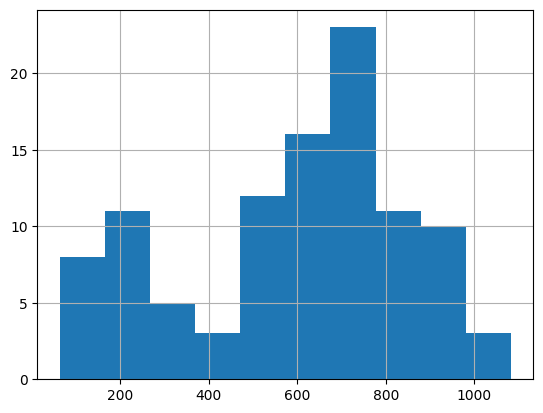

In [ ]:
reaction_df = pd.read_csv('files/one_per_phylum_training_data.csv', index_col=0)
reaction_df.sum().hist()

### Challenge:

Create a training dataset based on 10 Shewanella models

In [ ]:
# @title Solution

#path to training models
model_path =  './files/models/shewanella_models'

#list of model-ids of draft-models
paths  = os.listdir(model_path)
model_ids = []
for filename in paths:
    model_ids.append(filename[:-5])


shewanella_model_reaction_dic = {}
rxn = []
for file_path, model_id in zip(paths,model_ids):
    print(model_id)
    model = read_sbml_model(os.path.join(model_path, file_path))
    rs = set(model.reactions.list_attr('id'))
    shewanella_model_reaction_dic[model_id]=rs

    #generate a list of all possible reactions
    for i in list(rs):
         if i not in rxn and not i.startswith('EX_'):
             rxn.append(i)

#output path training data
output_path = './files/shewanella_training_data_example.csv'

shewanella_reaction_df=pd.DataFrame(index=rxn, columns=model_ids)

for key, value in shewanella_model_reaction_dic.items():
    a = []
    for i in rxn:
        if i in value:
            a.append(1)
        else:
            a.append(0)
    shewanella_reaction_df[key]=a

#saving to pandas file
shewanella_reaction_df.to_csv(output_path)


## Training the Neural Network

Now that we have prepared the training data, we can start training the network. During training the network will generate the feature by randomly deleting reactions from the input data and then try to predict the missing reactions.

We do this using the train function of the `NN_Trainer` class. This function will return a object of the predictor class (`NN_predictor`) containing the network, the reaction keys and modeltype. If a `output_path` is provided, it will also save it as a npz file.


In [ ]:
#Load in a our training sample
training_data_path = './files/one_per_phylum_training_data.csv'
training_data = pd.read_csv(training_data_path, index_col=0)

#set save path
save_path = './files/NN_phylum.npz'

#Train the network
NN_example = NN_Trainer.train(data=training_data, modeltype='ModelSEED',output_path=save_path)

print("The weights of the first layer of the network: \n{}".format(NN_example.network[0][0]))
print("The rxn_keys: \n{}".format(NN_example.rxn_keys.values))
print("The Modeltype: {}".format(NN_example.modeltype))

Num GPUs Available:  0
Saving network at: ./files/NN_phylum.npz
using data as labels
dataset created
training on data with shape: (3060, 1996) with 1482342.0 reactions
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 256)               511232    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 1996)              512972    
                                                                 
Total params: 1024204 (3.91 MB)
Trainable params: 1024204 (3.91 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Train on 3060 samples
Epoch 1/10
3060/3060 [==============================] - 2s 552us/sample - loss: 0.0514 - a

 By default the network in the NN_predictor is not a full tensorflow object but rather an array of the weights and biases of the different layers. It can still be used to make predictions while being less memory intensive by using matrix multiplication:

        a = input
        for layer in self.network:
            a = a.clip(0)
            a = ((a @ layer[0]) + layer[1])
        prediction =  1 / (1 + np.exp(-a))#sigmoid(a)
        
Which is build into the NN_Predictor class. You don't really have to know this, but it a fun way to see how neural networks work.

### Challenge:
Train a neural network specialised for the Shawanella genus.

 (Note: I have provided a full training dataset of all Shawanella models in the files folder as `shewanella_training_dataset.csv`)

In [ ]:
# @title Solution
#Load in a our training sample
shewanella_training_data_path = './files/shewanella_training_data.csv'
shewanella_training_data = pd.read_csv(shewanella_training_data_path, index_col=0)

#set save path
save_path = './files/NN_shewanella.npz'

#Train the network
NN_shewanella = NN_Trainer.train(data=shewanella_training_data, modeltype='ModelSEED',output_path=save_path)

Num GPUs Available:  0
Saving network at: ./files/NN_shewanella.npz
using data as labels
dataset created
training on data with shape: (2010, 1592) with 1961372.0 reactions
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 256)               407808    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1592)              409144    
                                                                 
Total params: 816952 (3.12 MB)
Trainable params: 816952 (3.12 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Train on 2010 samples
Epoch 1/10
2010/2010 [==============================] - 1s 478us/sample - loss: 0.0249 -

## Making predictions

As expected we can now use the network to make predictions directly using the predict funciton or have the gapfiller use the new network to gapfill models using the `trainedNNPath` argument from the gapfill class

#reactions not found in NN-keys:  65 / 726
Gap-filling database =  ModelSEED


ERROR:cobra.io.sbml:No objective coefficients in model. Unclear what should be optimized


#reactions not found in NN-keys:  65 / 726
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


GurobiError: Model too large for size-limited license; visit https://gurobi.com/unrestricted for more information

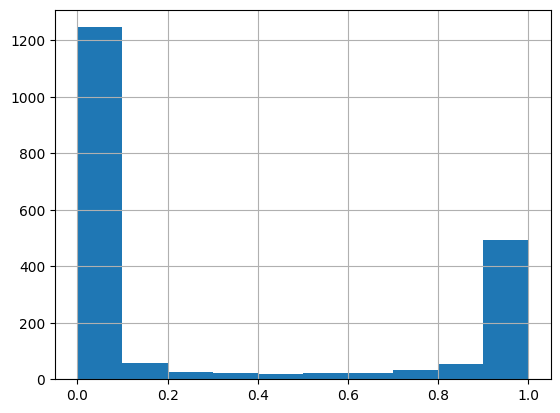

In [ ]:
path_to_draft_model = './files/Bifidobacterium adolescentis_atcc_15703.sbml'
draft_model = read_sbml_model(path_to_draft_model)
p = NN_example.predict(draft_model)
pd.Series(p).hist()
gapfill_model_custom_nn = Gapfill(draftModel = path_to_draft_model, objectiveName = 'bio1', trainedNNPath='./files/NN_phylum.npz')


### Challenge:

Use your newly trained network to gapfill any of the Shawanella models.

In [ ]:
# @title Solution
path_to_draft_model = './files/models/shewanella_models/23_shewanella_colwelliana_gca_001735525.sbml'
gapfill_model_shewanella = Gapfill(draftModel = path_to_draft_model, objectiveName = 'bio1', trainedNNPath='./files/NN_shewanella.npz')


# For the interested: Changing feature generation parameters

Basically you now know how to train networks but there are many additional changes you want to make during training.

During training the `generate_feature` function will automatically generate the training dataset. You can change several parameters for the generation of the feature:

1. You can change the number of times each training model is used (nuplo, default=30).
2. You can change the range of deletion percentages (min_for and max_for, default = 0.05 and 0.3), which will be removed in equal sized steps based on the number of replicates.
3. You can weigh the deletion of certain reactions (del_p, default=None).
4. You can also add false reactions (min_con and max_con) during training and change the weights of addition (con_p)*

*Note: we do not currently use this for dnngior as it would not work with the masking of input reactions as the mask does not differentiate between contamination and real reactions.

In the following example we set nuplo to 300 instead of 30, and we vary deletion between 0.2 and 0.5.

`custom_feature = NN_Trainer.generate_feature(training_data, nuplo=300, min_for = 0.2, max_for = 0.5)`

For convenience you can give the parameters to the train function and they will be passed on.

`network = NN_Trainer.train(data=training_data, nuplo=300, min_for=0.2, max_for=0.5, modeltype='ModelSEED',save=False)`

### Challenge

Train a neural network where the deletions are weighed by the frequency of the reaction

In [ ]:
# @title Solution
frequency = training_data.sum(axis=1)
network = NN_Trainer.train(training_data, del_p = frequency, modeltype='ModelSEED',save=False)

Num GPUs Available:  0
# WARNING: overwriting savefile
using data as labels


/usr/local/lib/python3.11/dist-packages/dnngior/NN_Trainer.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  del_p_norm = del_p[b]/np.sum(del_p[b])


dataset created
training on data with shape: (3060, 1996) with 1482342.0 reactions
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 256)               511232    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 1996)              512972    
                                                                 
Total params: 1024204 (3.91 MB)
Trainable params: 1024204 (3.91 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Train on 3060 samples
Epoch 1/10
3060/3060 [==============================] - 2s 672us/sample - loss: 0.0383 - auc_5: 0.9182 - precision_5: 0.8953 - recall_5: 0.6083
Epoch 2/10
3060/3060 [=========

# For the interested: Changing network parameters

Finally, you can rely on the default parameters to define the network which we optimised for our usecase, but for optimal perfomance on different datasets, you might want to change the hyperparameters (dropout, batch size), the architecture (nnodes, nlayers) or bias of predicted classes (bias0). You can also disable the masking of input positions during loss calculation (maskI=False).

You can also provide a validation split which will set apart a part of your input data during training and calculate scores after to validate your network.

###Challenge:

Train a network that can predict contamination instead of omissions.

In [ ]:
# @title Solution
network = NN_Trainer.train(data=training_data, maskI=False, min_con = 0.05, max_con=0.55, modeltype='ModelSEED',save=False)

# For the extra interested: Tensorflow object

By default the function returns a class with the simplified network but you very well might want instead the full Tensorflow network. To do this you can set return_full_network = True, which will change the NN_predictor to contain a Tensorflow network instead, there modeltype and rxn keys work the same. If you want to save this different class you need to change the file extension to .h5.

If you set return_history = True it will also return the history of training for optimisation purposes.

In [ ]:
save_path = os.path.join('files', 'NN_phylum.h5')
NN_tensorflow, history = NN_Trainer.train(data=training_data, return_full_network=True, modeltype='ModelSEED', output_path=save_path, return_history=True)

The main reason we dont use the full network is to save space and time, we can see that the tensorflow object is four times the size

In [ ]:
!ls files/NN_phylum* -lh

-rw-r--r-- 1 meine binf  16M Feb 28 16:52 NN_phylum.h5
-rw-r--r-- 1 meine binf 4.0M Feb 28 16:44 NN_phylum.npz


In [ ]:
print("The summary of the network: \n{}".format(NN_tensorflow.network.summary()))
print("The rxn_keys: \n{}".format(NN_tensorflow.rxn_keys))
print("The Modeltype: {}".format(NN_example.modeltype))

With the history you can do whatever you want, for example plot the loss function over the epochs.

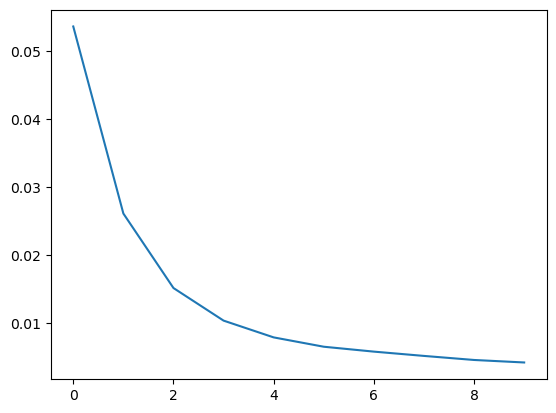

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])

By default the network will asume that your input (the data without deletions) should be what the network tries to predict. Alternatively, you can provide labels (the full set of reactions) for the network to try and predict. The following is a slightly convoluted way to have the network only predict missing reactions and have it predict reactions already present as 0.

In [ ]:
manual_feature = NN_Trainer.generate_feature(training_data.T, nuplo=30, min_con=0, max_con=0, min_for = 0.05, max_for = 0.3, del_p = None, con_p = None)
manual_training_data = pd.DataFrame(columns = training_data.index, data=manual_feature)
manual_labels = 1 - manual_feature

network = NN_Trainer.train(data=manual_training_data, rxn_keys=training_data.index, labels=manual_labels, maskI=False, min_for=0.0, max_for=0.0, modeltype='ModelSEED',save=False)